# Text Classification - Multilabel

### Using TF-IDF to classify topics on a multilabel problem

# Table of Content

* [Importing packages and loading data](#imp)
* [Data Exploration](#expl)
    * [Text Preprocessing](#preproc)
        * [Stemming](#stemming)
        * [TF-IDF](#tfidf)
* [Multi-Label Classification models](#multi)
    * [Train-Test Split](#sp)
    * [Multiple Binary - (One vs Rest Classifier)](#onevrest)

<a id='imp'></a>
# Importing packages and loading data

In [1]:
# Input data files are available in the "../data/" directory.
import pickle
import os
print(os.listdir("../data"))

# Basics + Viz
import pandas as pd
import numpy as np
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
from IPython.display import display

# Text pre-processing
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

# Models
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

#import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)

['20200422-multilabel.h5', '.ipynb_checkpoints', '0527_reddit_1300_parenting_clean.csv', 'labeled_only-reddit_796_of_1300.h5', '20200405-topic_to_id.pickle', '20200405-topic_per_row.h5']


In [2]:
# load data
df = pd.read_hdf('../data/20200422-multilabel.h5', 'all_results')

<a id='expl'></a>
# Data Exploration

Here we use the same data set, but prepared differently to make data exploration easier.<br>
Instead of each row containing 30 extra columns to stand for each and every possible topic it may be, all rows only contain one topic, but there are multiple rows with the same text.

In [3]:
explore_df = pd.read_hdf('../data/20200405-topic_per_row.h5', 'all_results')
with open("../data/20200405-topic_to_id.pickle", "rb") as input_file:
    topic_to_id = pickle.load(input_file)
id_to_topic = dict(zip(topic_to_id.values(), topic_to_id.keys()))

In [4]:
pd.DataFrame(explore_df.topics.unique()).values.shape

(30, 1)

The number of posts per topic are graphed out on the bar chart below. There are a few classses that account for most of the data, those classes being:
* Breastfeeding, Child Product
* Sleeping, Child Health, Pregnancy

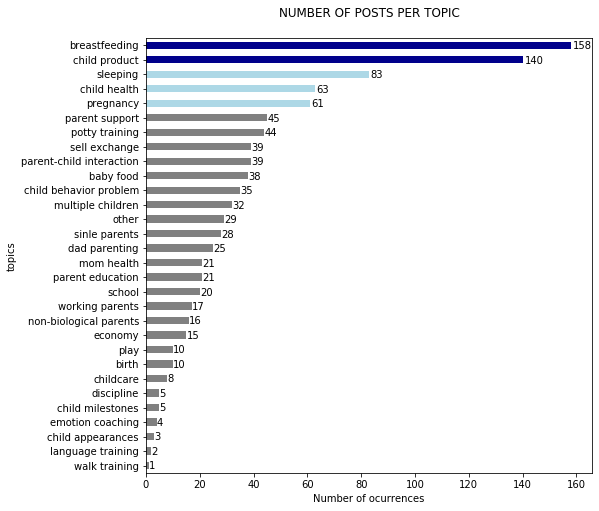

In [5]:
fig = plt.figure(figsize=(8,8))
colors = ['grey'] * 25 + ['lightblue'] * 3 + ['darkblue'] * 2
ax = explore_df.groupby('topics').text.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF POSTS PER TOPIC\n')
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width() * 1.005, p.get_y()))
plt.xlabel('Number of ocurrences', fontsize = 10);

<a id='preproc'></a>
## Text Preprocessing

<a id='stemming'></a>
### Stemming

In [6]:
stemmer = SnowballStemmer("english")

class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc : ([stemmer.stem(w) for w in analyzer(doc)])

In [7]:
stemmed = StemmedTfidfVectorizer(sublinear_tf=True, min_df=2,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each post into a vector
stemmed_features = stemmed.fit_transform(explore_df.text).toarray()

labels = explore_df.topic_id

print("STEMMED: %d rows, %d features each (unigrams and bigrams)" %(stemmed_features.shape))

STEMMED: 1017 rows, 12282 features each (unigrams and bigrams)


In [8]:
# Finding the three most correlated terms with each of the product categories
N = 3
for word, topic_id in sorted(topic_to_id.items()):
    stemmed_features_chi2 = chi2(stemmed_features, labels == topic_id)
    indices = np.argsort(stemmed_features_chi2[0])
    stemmed_feature_names = np.array(stemmed.get_feature_names())[indices]
    unigrams = [v for v in stemmed_feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in stemmed_feature_names if len(v.split(' ')) == 2]
    print("\n==> %s:" %(word))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))
#     print("  * At: %s" %(stemmed_features_chi2[0][indices][-2 * N:]))




==> baby food:
  * Most Correlated Unigrams are: ween, glorious, solid
  * Most Correlated Bigrams are: kid awesom, kinds bottl, different kind

==> birth:
  * Most Correlated Unigrams are: wednesday, midwif, section
  * Most Correlated Bigrams are: doing nedit, section babi, know gend

==> breastfeeding:
  * Most Correlated Unigrams are: breast, milk, pump
  * Most Correlated Bigrams are: ve pump, time pump, exclusively pump

==> child appearances:
  * Most Correlated Unigrams are: sd, johnson, hair
  * Most Correlated Bigrams are: week u2019m, u2019ve tri, u2019t car

==> child behavior problem:
  * Most Correlated Unigrams are: listen, voic, indoor
  * Most Correlated Bigrams are: throwing sho, won eat, older daught

==> child health:
  * Most Correlated Unigrams are: flu, nutramigen, vaccin
  * Most Correlated Bigrams are: feeling bett, like pain, spent night

==> child milestones:
  * Most Correlated Unigrams are: vocal, altogeth, displeasur
  * Most Correlated Bigrams are: sleep

<a id='tfidf'></a>
### TF-IDF
TfidfVectorizer class can be initialized with the following parameters:
* __min_df__: 2. remove the words from the vocabulary which have occurred in less than 2 files.
* __max_df__: remove the words from the vocabulary which have occurred in more than _‘max_df’ * total number of files in corpus_.
* __sublinear_tf__: True. scale the term frequency in logarithmic scale.
* __stop_words__: remove the predefined stop words in 'english'.
* __use_idf__: weight factor must use inverse document frequency.
* __ngram_range__: (1, 2) to indicate that unigrams and bigrams will be considered.

In [9]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=2,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each post into a vector
features = tfidf.fit_transform(explore_df.text).toarray()

labels = explore_df.topic_id

print("UNSTEMMED: %d rows, %d features each (unigrams and bigrams)" %(features.shape))

UNSTEMMED: 1017 rows, 13130 features each (unigrams and bigrams)


In [10]:
# Finding the three most correlated terms with each of the product categories
N = 3
for word, topic_id in sorted(topic_to_id.items()):
    features_chi2 = chi2(features, labels == topic_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("\n==> %s:" %(word))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))
#     print("  * At: %s" %(features_chi2[0][indices][-2 * N:]))




==> baby food:
  * Most Correlated Unigrams are: glorious, kinds, solids
  * Most Correlated Bigrams are: different kinds, start weening, little people

==> birth:
  * Most Correlated Unigrams are: image, midwife, section
  * Most Correlated Bigrams are: umbilical cord, doing nedit, know gender

==> breastfeeding:
  * Most Correlated Unigrams are: breast, pumping, pump
  * Most Correlated Bigrams are: breast feeding, breast milk, exclusively pumping

==> child appearances:
  * Most Correlated Unigrams are: sd, toddlers, hair
  * Most Correlated Bigrams are: u2019ve tried, ndoes suggestions, week u2019m

==> child behavior problem:
  * Most Correlated Unigrams are: tantrum, drives, voice
  * Most Correlated Bigrams are: throwing shoes, won eat, older daughter

==> child health:
  * Most Correlated Unigrams are: fever, doctor, nutramigen
  * Most Correlated Bigrams are: feeling better, spent night, daughter month

==> child milestones:
  * Most Correlated Unigrams are: displeasure, voca

The vanilla TF-IDF with no stemming applied leaves lots to be desired. Such as the topic *non-biological parents* having the top 3 unigrams show up as *adopting, adopted, adoption*.<br>
This problem is fixed with stemming applied to the vocabulary before hand. As the topic now shows *emot, biolog, adopt*. However, stemming will bring to surface words such as "Wednesday", and "Saturday" ending up in the top most correlated words.<br><br>

__[TODO]__: Think about adding more words to the stop word list (e.g. days of the week, maybe numbers?)

<a id='multi'></a>
# Multi-Label Classification models

<a id='sp'></a>
## Train-Test Split

test_size = 0.2

In [11]:
X = df['text']
y = df.drop(['text', 'label'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state = 0)

<a id='onevrest'></a>
## Multiple Binary - (One vs Rest Classifier)

This requires a different type of data. As we're building a binary classifier for each topic.<br>
Hence we're going to use a different format of data.

In [12]:
train, test = train_test_split(explore_df[['text', 'topic_id']],
                                test_size=0.2,
                                random_state = 0)

In [13]:
onevr = Pipeline(steps=[('stem',StemmedTfidfVectorizer()),
                         ('clasfi', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1))])

for i in range(len(topic_to_id)):
    print(f'Processing **{id_to_topic[i]}** posts...')
    
    # Training logistic regression model on train data
    onevr.fit(train['text'], train['topic_id'] == i)
    
    # calculating test accuracy
    prediction = onevr.predict(test['text'])
    temp_y = test['topic_id'].values == i
    print(classification_report(temp_y, prediction))
#     print(f'Test accuracy is {accuracy_score(temp_y, prediction)}')
    print("\n")

Processing **potty training** posts...
              precision    recall  f1-score   support

       False       0.96      1.00      0.98       194
        True       1.00      0.10      0.18        10

    accuracy                           0.96       204
   macro avg       0.98      0.55      0.58       204
weighted avg       0.96      0.96      0.94       204



Processing **other** posts...


/home/jupyter-jinu_jang/.conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.97      1.00      0.99       198
        True       0.00      0.00      0.00         6

    accuracy                           0.97       204
   macro avg       0.49      0.50      0.49       204
weighted avg       0.94      0.97      0.96       204



Processing **walk training** posts...
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       204

    accuracy                           1.00       204
   macro avg       1.00      1.00      1.00       204
weighted avg       1.00      1.00      1.00       204



Processing **economy** posts...


/home/jupyter-jinu_jang/.conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.98      1.00      0.99       200
        True       0.00      0.00      0.00         4

    accuracy                           0.98       204
   macro avg       0.49      0.50      0.50       204
weighted avg       0.96      0.98      0.97       204



Processing **child milestones** posts...
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       204

    accuracy                           1.00       204
   macro avg       1.00      1.00      1.00       204
weighted avg       1.00      1.00      1.00       204



Processing **childcare** posts...


/home/jupyter-jinu_jang/.conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       1.00      1.00      1.00       203
        True       0.00      0.00      0.00         1

    accuracy                           1.00       204
   macro avg       0.50      0.50      0.50       204
weighted avg       0.99      1.00      0.99       204



Processing **school** posts...


/home/jupyter-jinu_jang/.conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.99      1.00      1.00       202
        True       0.00      0.00      0.00         2

    accuracy                           0.99       204
   macro avg       0.50      0.50      0.50       204
weighted avg       0.98      0.99      0.99       204



Processing **child product** posts...
              precision    recall  f1-score   support

       False       0.87      0.99      0.93       177
        True       0.00      0.00      0.00        27

    accuracy                           0.86       204
   macro avg       0.43      0.50      0.46       204
weighted avg       0.75      0.86      0.80       204



Processing **mom health** posts...


/home/jupyter-jinu_jang/.conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.98      1.00      0.99       200
        True       0.00      0.00      0.00         4

    accuracy                           0.98       204
   macro avg       0.49      0.50      0.50       204
weighted avg       0.96      0.98      0.97       204



Processing **discipline** posts...


/home/jupyter-jinu_jang/.conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       1.00      1.00      1.00       203
        True       0.00      0.00      0.00         1

    accuracy                           1.00       204
   macro avg       0.50      0.50      0.50       204
weighted avg       0.99      1.00      0.99       204



Processing **baby food** posts...


/home/jupyter-jinu_jang/.conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.95      1.00      0.97       193
        True       0.00      0.00      0.00        11

    accuracy                           0.95       204
   macro avg       0.47      0.50      0.49       204
weighted avg       0.90      0.95      0.92       204



Processing **child behavior problem** posts...


/home/jupyter-jinu_jang/.conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.97      1.00      0.98       197
        True       0.00      0.00      0.00         7

    accuracy                           0.97       204
   macro avg       0.48      0.50      0.49       204
weighted avg       0.93      0.97      0.95       204



Processing **sinle parents** posts...


/home/jupyter-jinu_jang/.conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.96      1.00      0.98       196
        True       0.00      0.00      0.00         8

    accuracy                           0.96       204
   macro avg       0.48      0.50      0.49       204
weighted avg       0.92      0.96      0.94       204



Processing **child health** posts...


/home/jupyter-jinu_jang/.conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.93      1.00      0.96       190
        True       0.00      0.00      0.00        14

    accuracy                           0.93       204
   macro avg       0.47      0.50      0.48       204
weighted avg       0.87      0.93      0.90       204



Processing **sleeping** posts...
              precision    recall  f1-score   support

       False       0.95      1.00      0.97       190
        True       1.00      0.29      0.44        14

    accuracy                           0.95       204
   macro avg       0.97      0.64      0.71       204
weighted avg       0.95      0.95      0.94       204



Processing **pregnancy** posts...


/home/jupyter-jinu_jang/.conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.96      1.00      0.98       195
        True       0.00      0.00      0.00         9

    accuracy                           0.96       204
   macro avg       0.48      0.50      0.49       204
weighted avg       0.91      0.96      0.93       204



Processing **parent-child interaction** posts...


/home/jupyter-jinu_jang/.conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.97      1.00      0.99       198
        True       0.00      0.00      0.00         6

    accuracy                           0.97       204
   macro avg       0.49      0.50      0.49       204
weighted avg       0.94      0.97      0.96       204



Processing **language training** posts...


/home/jupyter-jinu_jang/.conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       1.00      1.00      1.00       203
        True       0.00      0.00      0.00         1

    accuracy                           1.00       204
   macro avg       0.50      0.50      0.50       204
weighted avg       0.99      1.00      0.99       204



Processing **parent education** posts...


/home/jupyter-jinu_jang/.conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.99      1.00      0.99       201
        True       0.00      0.00      0.00         3

    accuracy                           0.99       204
   macro avg       0.49      0.50      0.50       204
weighted avg       0.97      0.99      0.98       204



Processing **emotion coaching** posts...


/home/jupyter-jinu_jang/.conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.99      1.00      1.00       202
        True       0.00      0.00      0.00         2

    accuracy                           0.99       204
   macro avg       0.50      0.50      0.50       204
weighted avg       0.98      0.99      0.99       204



Processing **dad parenting** posts...


/home/jupyter-jinu_jang/.conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.99      1.00      0.99       201
        True       0.00      0.00      0.00         3

    accuracy                           0.99       204
   macro avg       0.49      0.50      0.50       204
weighted avg       0.97      0.99      0.98       204



Processing **breastfeeding** posts...
              precision    recall  f1-score   support

       False       0.88      1.00      0.94       174
        True       1.00      0.20      0.33        30

    accuracy                           0.88       204
   macro avg       0.94      0.60      0.63       204
weighted avg       0.90      0.88      0.85       204



Processing **play** posts...


/home/jupyter-jinu_jang/.conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.98      1.00      0.99       200
        True       0.00      0.00      0.00         4

    accuracy                           0.98       204
   macro avg       0.49      0.50      0.50       204
weighted avg       0.96      0.98      0.97       204



Processing **sell exchange** posts...


/home/jupyter-jinu_jang/.conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.95      1.00      0.97       194
        True       0.00      0.00      0.00        10

    accuracy                           0.95       204
   macro avg       0.48      0.50      0.49       204
weighted avg       0.90      0.95      0.93       204



Processing **parent support** posts...


/home/jupyter-jinu_jang/.conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.93      1.00      0.96       190
        True       0.00      0.00      0.00        14

    accuracy                           0.93       204
   macro avg       0.47      0.50      0.48       204
weighted avg       0.87      0.93      0.90       204



Processing **non-biological parents** posts...


/home/jupyter-jinu_jang/.conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.99      1.00      1.00       202
        True       0.00      0.00      0.00         2

    accuracy                           0.99       204
   macro avg       0.50      0.50      0.50       204
weighted avg       0.98      0.99      0.99       204



Processing **multiple children** posts...


/home/jupyter-jinu_jang/.conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.97      1.00      0.99       198
        True       0.00      0.00      0.00         6

    accuracy                           0.97       204
   macro avg       0.49      0.50      0.49       204
weighted avg       0.94      0.97      0.96       204



Processing **child appearances** posts...
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       204

    accuracy                           1.00       204
   macro avg       1.00      1.00      1.00       204
weighted avg       1.00      1.00      1.00       204



Processing **working parents** posts...


/home/jupyter-jinu_jang/.conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.98      1.00      0.99       200
        True       0.00      0.00      0.00         4

    accuracy                           0.98       204
   macro avg       0.49      0.50      0.50       204
weighted avg       0.96      0.98      0.97       204



Processing **birth** posts...
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       203
        True       0.00      0.00      0.00         1

    accuracy                           1.00       204
   macro avg       0.50      0.50      0.50       204
weighted avg       0.99      1.00      0.99       204





/home/jupyter-jinu_jang/.conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
top5 = []
for topic in ['breastfeeding', 'child product',
            'sleeping', 'child health', 'pregnancy']:
    top5.append(topic_to_id[topic])
    

train, test = train_test_split(explore_df[['text', 'topic_id']],
                                test_size=0.2,
                                random_state = 0)
    
for i in top5:
    print(f'Processing **{id_to_topic[i]}** posts...')
    
    # Training logistic regression model on train data
    onevr.fit(train['text'], train['topic_id'] == i)
    
    # calculating test accuracy
    prediction = onevr.predict(test['text'])
    temp_y = test['topic_id'].values == i
    print(classification_report(temp_y, prediction))
#     print(f'Test accuracy is {accuracy_score(temp_y, prediction)}')
    print("\n")

Processing **breastfeeding** posts...
              precision    recall  f1-score   support

       False       0.88      1.00      0.94       174
        True       1.00      0.20      0.33        30

    accuracy                           0.88       204
   macro avg       0.94      0.60      0.63       204
weighted avg       0.90      0.88      0.85       204



Processing **child product** posts...
              precision    recall  f1-score   support

       False       0.87      0.99      0.93       177
        True       0.00      0.00      0.00        27

    accuracy                           0.86       204
   macro avg       0.43      0.50      0.46       204
weighted avg       0.75      0.86      0.80       204



Processing **sleeping** posts...
              precision    recall  f1-score   support

       False       0.95      1.00      0.97       190
        True       1.00      0.29      0.44        14

    accuracy                           0.95       204
   macro avg   

/home/jupyter-jinu_jang/.conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.93      1.00      0.96       190
        True       0.00      0.00      0.00        14

    accuracy                           0.93       204
   macro avg       0.47      0.50      0.48       204
weighted avg       0.87      0.93      0.90       204



Processing **pregnancy** posts...
              precision    recall  f1-score   support

       False       0.96      1.00      0.98       195
        True       0.00      0.00      0.00         9

    accuracy                           0.96       204
   macro avg       0.48      0.50      0.49       204
weighted avg       0.91      0.96      0.93       204





/home/jupyter-jinu_jang/.conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
